In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Análise Exploratória

In [ ]:
df = pd.read_csv('dataset.csv')
df.head()

,texto,label
0,"– Não. Eu me calei a vida toda. Mas está bem, ...",1
1,O espelho vê-se apenas na ponta do peito e ao ...,0
2,E eis que meu mal me domina. Sou ainda a cruel...,1
3,Que farei então? Deverei continuar a acertar e...,1
4,"A janela de um edifício, fechada por janelas f...",0


In [ ]:
# Configuração do NLTK (Stopwords em Português)
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

# Adiciona algumas palavras comuns que poluem a nuvem
stop_words.update(['que', 'de', 'a', 'o', 'e', 'do', 'da', 'em', 'um', 'uma', 'para', 'com', 'não', 'é', 'os', 'as'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


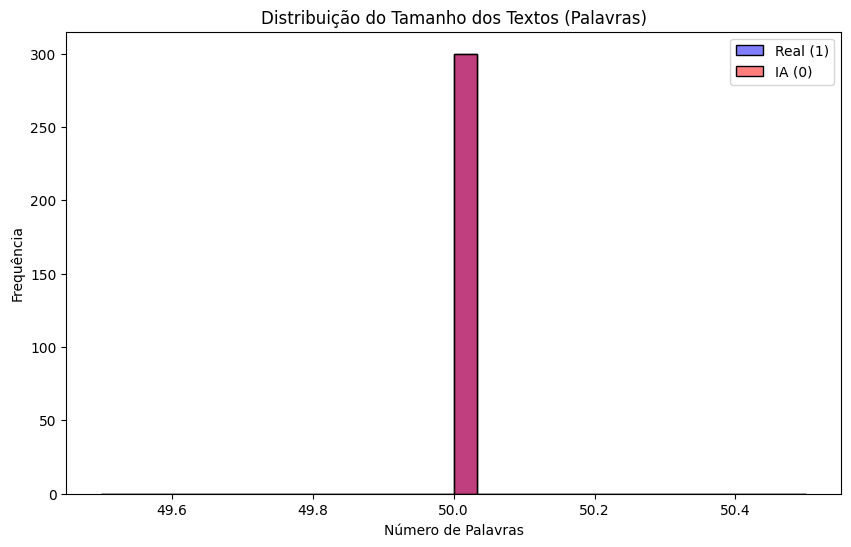

In [ ]:
plt.figure(figsize=(10, 6))

# Cria coluna de contagem de palavras
df['num_palavras'] = df['texto'].apply(lambda x: len(str(x).split()))

sns.histplot(data=df, x='num_palavras', hue='label', kde=True, palette=['red', 'blue'], bins=30)

plt.title('Distribuição do Tamanho dos Textos (Palavras)')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.legend(labels=['Real (1)', 'IA (0)'])
plt.show()

In [ ]:
# Estatísticas
media_ia = df[df['label']==0]['num_palavras'].mean()
media_real = df[df['label']==1]['num_palavras'].mean()
print(f"📝 Média de palavras/texto:")
print(f"   IA (Falso): {media_ia:.1f}")
print(f"   Clarice (Real): {media_real:.1f}")

📝 Média de palavras/texto:
   IA (Falso): 50.0
   Clarice (Real): 50.0


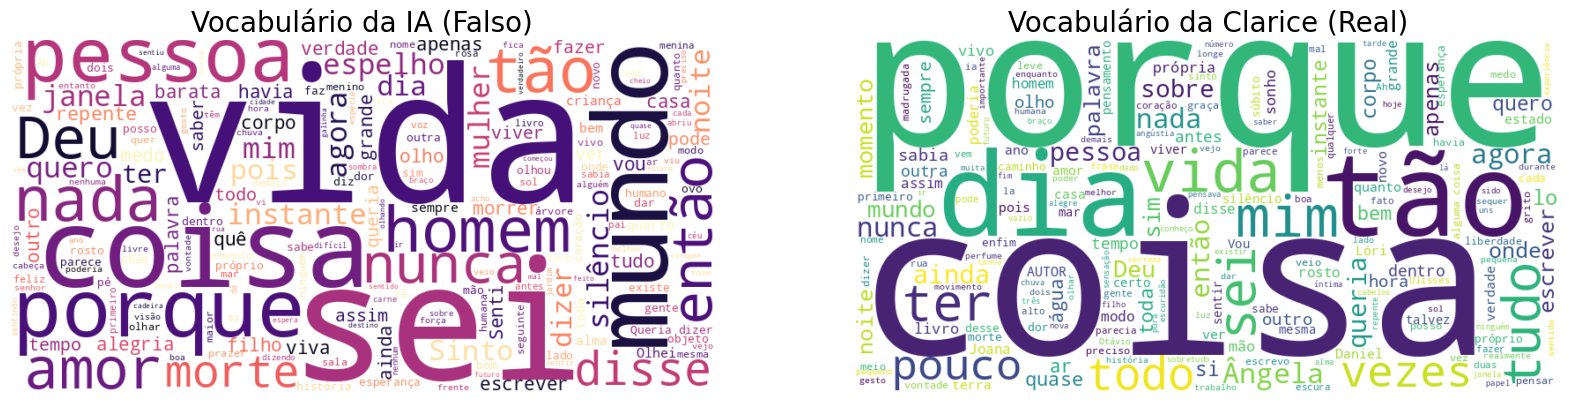

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Nuvem IA
texto_ia = " ".join(df[df['label'] == 0]['texto'].astype(str))
wc_ia = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, colormap='magma').generate(texto_ia)
axes[0].imshow(wc_ia, interpolation='bilinear')
axes[0].set_title("Vocabulário da IA (Falso)", fontsize=20)
axes[0].axis('off')

# Nuvem Real
texto_real = " ".join(df[df['label'] == 1]['texto'].astype(str))
wc_real = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, colormap='viridis').generate(texto_real)
axes[1].imshow(wc_real, interpolation='bilinear')
axes[1].set_title("Vocabulário da Clarice (Real)", fontsize=20)
axes[1].axis('off')

plt.show()

# Pré-processamento

In [ ]:
X = df['texto']
y = df['label']

# Passo 1: Separar Treino (60%) do Resto (40%)
# test_size=0.4 significa que 40% vai para o temporário
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Passo 2: Separar o Resto (40%) em metades iguais -> Validação (20%) e Teste (20%)
# test_size=0.5 divide o X_temp exatamente ao meio
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"   📐 Treino (60%):    {len(X_train)} amostras")
print(f"   📐 Validação (20%): {len(X_val)} amostras")
print(f"   📐 Teste (20%):     {len(X_test)} amostras")

   📐 Treino (60%):    360 amostras
   📐 Validação (20%): 120 amostras
   📐 Teste (20%):     120 amostras


In [ ]:
# Configuração:
# - ngram_range=(1, 2): Palavras soltas e pares ("vida", "a vida")
# - min_df=2: Ignora palavras que aparecem em menos de 2 textos (typos/ruído)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2)

# Fit APENAS no Treino
X_train_vec = vectorizer.fit_transform(X_train)

X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

print(f"Matriz Treino: {X_train_vec.shape}")
print(f"Matriz Val:    {X_val_vec.shape}")
print(f"Matriz Teste:  {X_test_vec.shape}")

assert X_train_vec.shape[1] == X_val_vec.shape[1] == X_test_vec.shape[1]

Matriz Treino: (360, 2666)
Matriz Val:    (120, 2666)
Matriz Teste:  (120, 2666)


# Modelagem

In [ ]:
# max_iter=1000 garante que o modelo tenha tempo de encontrar a melhor solução matemática
clf = LogisticRegression(random_state=42, max_iter=1000)

# Treina apenas nos dados de TREINO (60%)
clf.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Predição
y_pred_val = clf.predict(X_val_vec)

In [ ]:
# Métricas
acc_val = accuracy_score(y_val, y_pred_val)
cm_val = confusion_matrix(y_val, y_pred_val)
print(f"Acurácia: {acc_val:.2%}")

Acurácia: 76.67%


In [ ]:
print(classification_report(y_val, y_pred_val, target_names=['IA', 'Real']))

              precision    recall  f1-score   support

          IA       0.79      0.73      0.76        60
        Real       0.75      0.80      0.77        60

    accuracy                           0.77       120
   macro avg       0.77      0.77      0.77       120
weighted avg       0.77      0.77      0.77       120



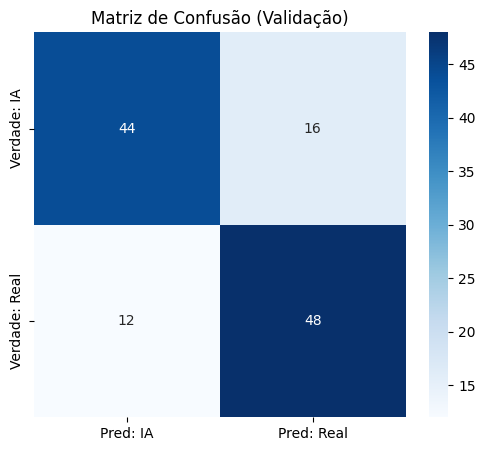

In [ ]:
# Matriz de Confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: IA', 'Pred: Real'],
            yticklabels=['Verdade: IA', 'Verdade: Real'])
plt.title('Matriz de Confusão (Validação)')
plt.show()

In [ ]:
# Vamos ver o que ele considera "palavra de IA" vs "palavra de Clarice"
feature_names = vectorizer.get_feature_names_out()
coefs = clf.coef_[0]

# Ordena: Negativos = IA (Classe 0), Positivos = Real (Classe 1)
top_ia = sorted(zip(coefs, feature_names))[:10]
top_real = sorted(zip(coefs, feature_names), reverse=True)[:10]

print("🤖 Palavras que o modelo associa à IA:")
print([x[1] for x in top_ia])

print("📖 Palavras que o modelo associa à Clarice:")
print([x[1] for x in top_real])

🤖 Palavras que o modelo associa à IA:
['eu', 'estava', 'não', 'silêncio', 'mulher', 'só', 'você', 'meu', 'mundo', 'sou']
📖 Palavras que o modelo associa à Clarice:
['ângela', 'de', 'seus', 'pouco', 'onde', 'sobre', 'seu', 'um pouco', 'ar', 'talvez']


# Otimização de Hiperparâmetros

In [ ]:
# Criamos um Pipeline: Primeiro vetoriza, depois classifica.
# Isso permite testar parâmetros do TF-IDF e da Regressão ao mesmo tempo.
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42, max_iter=2000))
])

In [ ]:
# A Grade de Parâmetros para testar
param_grid = {
    'tfidf__max_features': [3000, 5000, 7000], # Testar vocabulários maiores
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], # Palavras, Pares ou Trios?
    'clf__C': [0.1, 1, 10, 100], # Força da regularização
    'clf__solver': ['liblinear', 'lbfgs'] # Algoritmo matemático
}

# Configura a busca (Cross-Validation com 5 dobras)
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(max_iter=2000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__solver': ['liblinear', 'lbfgs'],
                         'tfidf__max_features': [3000, 5000, 7000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy', verbose=1)

In [ ]:
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Melhor Acurácia no Treino (CV): {grid_search.best_score_:.2%}")

Melhores Parâmetros: {'clf__C': 100, 'clf__solver': 'liblinear', 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 1)}
Melhor Acurácia no Treino (CV): 80.83%


In [ ]:
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)
acc_val = accuracy_score(y_val, y_pred_val)
cm = confusion_matrix(y_val, y_pred_val)

In [ ]:
print(f"Acurácia na Validação: {acc_val:.2%}")

Acurácia na Validação: 78.33%


In [ ]:
print(classification_report(y_val, y_pred_val, target_names=['IA', 'Real']))

              precision    recall  f1-score   support

          IA       0.76      0.83      0.79        60
        Real       0.81      0.73      0.77        60

    accuracy                           0.78       120
   macro avg       0.79      0.78      0.78       120
weighted avg       0.79      0.78      0.78       120



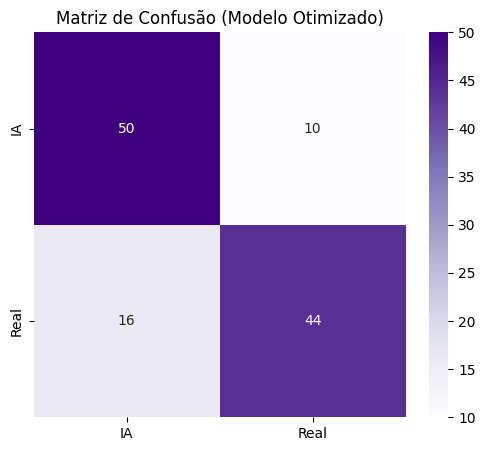

In [ ]:
# Matriz
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['IA', 'Real'], yticklabels=['IA', 'Real'])
plt.title('Matriz de Confusão (Modelo Otimizado)')
plt.show()

# Avaliação Final

In [ ]:
# O GridSearch disse que ngram_range=(1,1) e max_features=3000 eram os melhores.
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 1))

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
# O GridSearch disse que C=100 e solver='liblinear' eram os melhores.
clf = LogisticRegression(C=100, solver='liblinear', random_state=42)
clf.fit(X_train_vec, y_train)

LogisticRegression(C=100, random_state=42, solver='liblinear')

In [ ]:
y_pred = clf.predict(X_test_vec)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

In [ ]:
print(f"Acurácia Final: {acc:.2%}")

Acurácia Final: 85.83%


In [ ]:
print(classification_report(y_test, y_pred, target_names=['IA', 'Real']))

              precision    recall  f1-score   support

          IA       0.79      0.97      0.87        60
        Real       0.96      0.75      0.84        60

    accuracy                           0.86       120
   macro avg       0.88      0.86      0.86       120
weighted avg       0.88      0.86      0.86       120



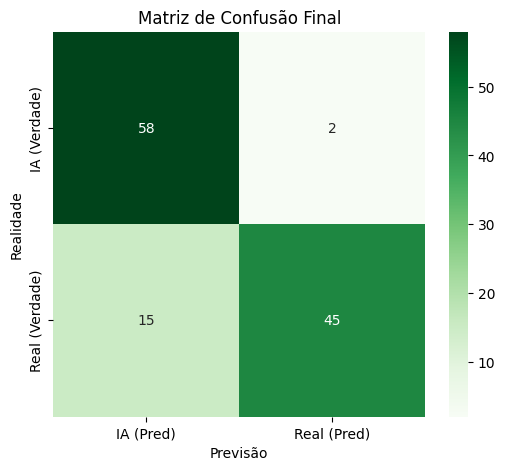

In [ ]:
# Matriz de Confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['IA (Pred)', 'Real (Pred)'],
            yticklabels=['IA (Verdade)', 'Real (Verdade)'])
plt.title('Matriz de Confusão Final')
plt.ylabel('Realidade')
plt.xlabel('Previsão')
plt.show()

In [ ]:
feature_names = vectorizer.get_feature_names_out()
coefs = clf.coef_[0]

top_ia = sorted(zip(coefs, feature_names))[:10]
top_real = sorted(zip(coefs, feature_names), reverse=True)[:10]

print(f"Palavras viciadas da IA: {[x[1] for x in top_ia]}")
print(f"Palavras que a IA esqueceu: {[x[1] for x in top_real]}")

Palavras viciadas da IA: ['eu', 'estava', 'silêncio', 'mulher', 'meu', 'não', 'mundo', 'janela', 'no', 'uma']
Palavras que a IA esqueceu: ['ângela', 'seus', 'acumulando', 'pouco', 'isto', 'anos', 'número', 'sensação', 'agudez', 'onde']
